In [84]:
import sys
from pathlib import Path
from copy import deepcopy
from collections import Counter
from random import randint, seed
import time
# from os.path import exists

# Add the path to the sys.path list
sys.path.append(Path(Path.cwd(), "..", "galfitlib").as_posix())

In [2]:
#from galfitlib.classes.components import *
from galfitlib.classes.containers import *
from galfitlib.functions.helper_functions import *
from galfitlib.pipeline.s2g_feedme_gen import *

In [3]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from scipy import fft
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import librosa
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio

In [5]:
import sounddevice as sd

In [6]:
# # From the twelve-tone tuning system
notes = [
    ['C0', 16.35],
    ['C#0/Db0', 17.32],
    ['D0', 18.35],
    ['D#0/Eb0', 19.45],
    ['E0', 20.60],
    ['F0', 21.83],
    ['F#0/Gb0', 23.12],
    ['G0', 24.50],
    ['G#0/Ab0', 25.96],
    ['A0', 27.50],
    ['A#0/Bb0', 29.14],
    ['B0', 30.87],
    ['C1', 32.70],
    ['C#1/Db1', 34.65],
    ['D1', 36.71],
    ['D#1/Eb1', 38.89],
    ['E1', 41.20],
    ['F1', 43.65],
    ['F#1/Gb1', 46.25],
    ['G1', 49.00],
    ['G#1/Ab1', 51.91],
    ['A1', 55.00],
    ['A#1/Bb1', 58.27],
    ['B1', 61.74],
    ['C2', 65.41],
    ['C#2/Db2', 69.30],
    ['D2', 73.42],
    ['D#2/Eb2', 77.78],
    ['E2', 82.41],
    ['F2', 87.31],
    ['F#2/Gb2', 92.50],
    ['G2', 98.00],
    ['G#2/Ab2', 103.83],
    ['A2', 110.00],
    ['A#2/Bb2', 116.54],
    ['B2', 123.47],
    ['C3', 130.81],
    ['C#3/Db3', 138.59],
    ['D3', 146.83],
    ['D#3/Eb3', 155.56],
    ['E3', 164.81],
    ['F3', 174.61],
    ['F#3/Gb3', 185.00],
    ['G3', 196.00],
    ['G#3/Ab3', 207.65],
    ['A3', 220.00],
    ['A#3/Bb3', 233.08],
    ['B3', 246.94],
    ['C4', 261.63],
    ['C#4/Db4', 277.18],
    ['D4', 293.66],
    ['D#4/Eb4', 311.13],
    ['E4', 329.63],
    ['F4', 349.23],
    ['F#4/Gb4', 369.99],
    ['G4', 392.00],
    ['G#4/Ab4', 415.30],
    ['A4', 440.00],
    ['A#4/Bb4', 466.16],
    ['B4', 493.88],
    ['C5', 523.25],
    ['C#5/Db5', 554.37],
    ['D5', 587.33],
    ['D#5/Eb5', 622.25],
    ['E5', 659.25],
    ['F5', 698.46],
    ['F#5/Gb5', 739.99],
    ['G5', 783.99],
    ['G#5/Ab5', 830.61],
    ['A5', 880.00],
    ['A#5/Bb5', 932.33],
    ['B5', 987.77],
    ['C6', 1046.50],
    ['C#6/Db6', 1108.73],
    ['D6', 1174.66],
    ['D#6/Eb6', 1244.51	],
    ['E6', 1318.51],
    ['F6', 1396.91],
    ['F#6/Gb6', 1479.98],
    ['G6', 1567.98],
    ['G#6/Ab6', 1661.22],
    ['A6', 1760.00	],
    ['A#6/Bb6', 1864.66],
    ['B6', 1975.53	],
    ['C7', 2093.00],
    ['C#7/Db7', 2217.46],
    ['D7', 2349.32],
    ['D#7/Eb7', 2489.02],
    ['E7', 2637.02],
    ['F7', 2793.83],
    ['F#7/Gb7 ', 2959.96],
    ['G7', 3135.96],
    ['G#7/Ab7', 3322.44],
    ['A7', 3520.00],
    ['A#7/Bb7', 3729.31],
    ['B7', 3951.07],
    ['C8', 4186.01],
    ['C#8/Db8', 4434.92],
    ['D8', 4698.63],
    ['D#8/Eb8', 4978.03],
    ['E8', 5274.04],
    ['F8', 5587.65],
    ['F#8/Gb8', 5919.91],
    ['G8', 6271.93],
    ['G#8/Ab8', 6644.88	],
    ['A8', 7040.00],
    ['A#8/Bb8', 7458.62],
    ['B8', 7902.13],
]

In [7]:
note_dict_ranges = {}
previous_tone_number = "0"
previous_name        = None
for name, freq in notes:
    name = name.replace("#", "").replace("b", "").strip()
    
    current_tone_number = name[-1]
    
    # There are gaps when jumping to different numbers
    if current_tone_number != previous_tone_number:
        note_dict_ranges[previous_name].append(freq)
        
    note_letter_1 = name
    note_letter_2 = None
    
    if "/" in name:
        note_letter_1, note_letter_2 = name.split("/")
        #note_letter_1 = note_letter_1[0]
        #note_letter_2 = note_letter_2[0]
        
        note_dict_ranges[note_letter_1].append(freq)
        note_dict_ranges[note_letter_2] = [freq]
        
    else:
        if note_letter_1 not in note_dict_ranges:
            note_dict_ranges[note_letter_1] = [freq]
        else:
            note_dict_ranges[note_letter_1].append(freq)
            
    previous_tone_number = current_tone_number
    previous_name        = name

In [9]:
#note_dict_rangesa
ranges_for_search = [                                                    
    {
        "start" : freqs[0],                      
        "end"   : freqs[-1],                           
        "value" : note
    }                        
    for note, freqs in note_dict_ranges.items()
]
#ranges_for_search

In [10]:
def binary_search_ranges(ranges, values : list) -> list[tuple[str, float]]:
    """
    Wrapper for binary search on a list of values in a list of ranges
    """
    def binary_search(ranges : list, value : float) -> tuple[str, float]:
        """
        Binary search for a value in a list of ranges
        Thanks to https://stackoverflow.com/a/65518827 for the code
        
        Parameters
        ----------
        ranges : list
            List of dictionaries containing the frequency ranges to search
        value : float
            Value to search for
            
        Returns
        -------
        str
            Note corresponding to the value
        float
            Difference between the value and the start of the frequency range
        """
    
        if len(ranges) == 1:
            if ranges[0]["start"] <= value <= ranges[0]["end"]:
                pass
            else:
                print(f"Value ({value:.2f}) not found in *any* range.")
                print(f"Choosing note: {ranges[0]['value']}")
                
            # Normalize the difference wrt the total length of the range
            # Maximum value is 1 so if a value is at the beyond the range, 
            # in the case of gaps (per above) it will be set to 1
            range_len = ranges[0]["end"] - ranges[0]["start"]
            return (
                ranges[0]["value"], 
                min(
                        (value - ranges[0]["start"])/range_len, 1
                )
            )
    
        mid = len(ranges) // 2
        if ranges[mid]["end"] < value:
            return binary_search(ranges[mid:], value)
        elif ranges[mid]["start"] > value:
            return binary_search(ranges[:mid], value)
        else:
            # Normalize the difference wrt the total length of the range
            range_len = ranges[mid]["end"] - ranges[mid]["start"]
            return (
                ranges[mid]["value"], 
                (value - ranges[mid]["start"])/range_len
            )
        
    return [binary_search(ranges_for_search, value) for value in values]
    #yield binary_search(ranges_for_search, value)

In [67]:
g_prefix = "galaxy"
g_number = 0

cwd = Path.cwd()

IN_DIR  = pj(cwd, "music-in")
TMP_DIR = pj(cwd, "music-tmp")
OUT_DIR = pj(cwd, "music-out")

previous = False

In [69]:
# Function to update the array image when slider value changes
def update_image_array(change):
    # Update the image data based on the slider value
    new_image_data_array = image_data_array * change.new

    # Update the array image with new data
    image_array.set_data(new_image_data_array)

    # Redraw the figure
    fig.canvas.draw()

In [77]:
if __name__ == "__main__":
    plt.clf()
    
    gname = "template"
    music_filename = "brown_alma_mater.mp3"
    
    height = 1000
    width  = 1000
    # square
    model_dim    = 200
    model_offset = model_dim//2

    initial_seed_value = 42
    
    image_array = np.zeros((height, width))
    
    list_o_notes = []
    volumes      = []
    all_models   = []
    
    if not exists(pj(OUT_DIR, gname)):
        pj(OUT_DIR, gname).mkdir()
    
    feedme_0          = pj(OUT_DIR, gname, f"{gname}.in")
    input_filename_0  = pj(IN_DIR, f"{gname}.fits")
    output_filename_0 = pj(OUT_DIR, gname, f"{gname}.fits")
    
    delay = 0.5
    signal, sample_rate, time_array = load_audio(music_filename, delay = delay)
    
    # Every 2 seconds
    time_step   = 2
    t_step_size = time_step * sample_rate
    t_initial   = int(delay * sample_rate) + t_step_size
        
    # Written as such to prepare for async processing
    for t_step in range(t_initial, len(time_array), t_step_size):
        
        selected_peaks, volume = time_step_analysis(signal, sample_rate)
        peak_notes = binary_search_ranges(ranges_for_search, selected_peaks)
        if peak_notes is None:
            continue
        
        list_o_notes.append(peak_notes)
        volumes.append(volume)
    
    # Flatten the list of lists of notes for Counter
    flattened_list_o_notes = [note[0] for sublist in list_o_notes for note in sublist]
    
    # Counter does not sort by frequency, so we need to sort it
    sorted_counter = {
        k : v for k, v in sorted(
                Counter(flattened_list_o_notes).items(), key=lambda item: item[1], 
                reverse = True
        )
    }
    
    note_priority_map = {
        note : priority_num 
        for priority_num, note in enumerate(
                sorted_counter.keys()
        )
    }
    
    # Normalize volumes
    volumes      = np.array(volumes)
    max_volume   = np.max(volumes)
    min_volume   = np.min(volumes)
    
    norm_volumes = (volumes - min_volume)/(max_volume - min_volume)
    
    seed_value = initial_seed_value
    for i, (notes_chunk, norm_volume) in enumerate(zip(list_o_notes, norm_volumes)):
        
        # Leaving this as such can allow me to debug things later
        # Based on their coordinates in the image
        seed(seed_value)
        x_pos = randint(model_offset, width  - model_offset)
        y_pos = randint(model_offset, height - model_offset)
        seed_value += 1
        
        output_filename = galfitting(
                feedme_0, 
                input_filename_0, 
                output_filename_0, 
                gname,
                x_pos, 
                y_pos, 
                model_offset,
                note_priority_map,
                notes_chunk, 
                norm_volume, 
                i
        )
        
        image_array += process_galfit_output(
                output_filename, 
                height, 
                width,
                x_pos, 
                y_pos,
                model_dim,
                model_offset
        )
        

Value (688.00) not found in *any* range.
Choosing note: E5
Value (689.00) not found in *any* range.
Choosing note: E5
Value (695.95) not found in *any* range.
Choosing note: E5
Value (688.50) not found in *any* range.
Choosing note: E5
Value (688.00) not found in *any* range.
Choosing note: E5
Value (688.17) not found in *any* range.
Choosing note: E5


<Figure size 640x480 with 0 Axes>

In [78]:
%matplotlib inline
#%matplotlib notebook

<Figure size 640x480 with 0 Axes>

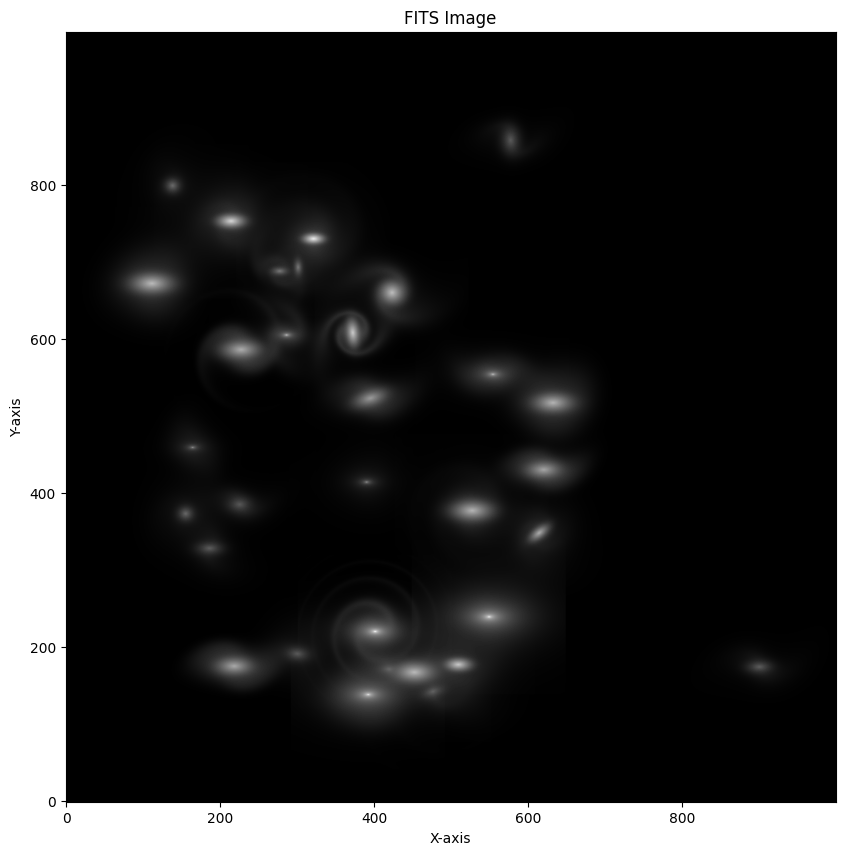

In [79]:
plt.clf()
# Create a figure and subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

# Performing a logarithmic transformation of the image data
scaling_constant = 255/np.log(1 + np.max(image_array))
# Display the FITS image after scaling
image_fits = ax1.imshow(scaling_constant * np.log(1 + image_array), cmap='gray')

# Create a slider widget for the FITS image
# slider_fits = widgets.FloatSlider(value = 1.0, min = 0.0, max = 2.0, step=0.01, description='FITS Scale:', continuous_update=True)

# Function to update the FITS image when slider value changes
def update_image_fits(change):
    # Update the image data based on the slider value
    new_image_data_fits = change.new * np.log(1 + image_data_fits)

    # Update the FITS image with new data
    image_fits.set_data(new_image_data_fits)

    # Redraw the figure
    fig.canvas.draw()

# Attach the update_image_fits function to the FITS slider's value change event
# slider_fits.observe(update_image_fits, 'value')

# Display the slider widgets
# display(widgets.HBox([slider_fits])) #, slider_array]))

# Add any additional customization you need to the subplots
ax1.set_title('FITS Image')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.invert_yaxis()

# Show the plot
plt.show()
fig.savefig("mosaic.png", dpi = fig.dpi)

In [ ]:
def live():
    plt.clf()
    
    gname = "template"
    music_filename = "brown_alma_mater.mp3"
    
    height = 1000
    width  = 1000
    # square
    model_dim    = 200
    model_offset = model_dim//2
    
    initial_seed_value = 42
    
    image_array = np.zeros((height, width))
    
    list_o_notes = []
    volumes      = []
    all_models   = []
    
    if not exists(pj(OUT_DIR, gname)):
        pj(OUT_DIR, gname).mkdir()
    
    feedme_0          = pj(OUT_DIR, gname, f"{gname}.in")
    input_filename_0  = pj(IN_DIR, f"{gname}.fits")
    output_filename_0 = pj(OUT_DIR, gname, f"{gname}.fits")
    
    delay = 0.5
    signal, sample_rate, time_array = load_audio(music_filename, delay = delay)
    
    #song_duration = librosa.get_duration(path = music_filename)
    
    # Every 0.5 seconds for determination of peaks
    small_time_step = 0.5
    
    # A new galaxy every 2 seconds
    big_time_step   = 2
    
    play_audio(signal, sample_rate)
    
    def callback(in_data, frames, time, status):
        """
        Callback function for the audio stream
        """
        #global signal
        signal = np.frombuffer(in_data, dtype = np.float32)
        return signal # , pyaudio.paContinue)
    
    with sd.InputStream(
            samplerate = sample_rate, 
            channels = 1, 
            callback = callback
    ):       
        # signal = record_audio(sample_rate, small_time_step)
        
        # Start a timer to process the audio every small_time_step seconds
        start_time = time.time()
        while True:
            current_time = time.time()
            if current_time - start_time >= small_time_step:
                peak_notes, volume = time_step_analysis(signal, sample_rate)

                if peak_notes is None:
                    continue
                        
                list_o_notes.append(peak_notes)
                volumes.append(volume)
                        
                start_time = current_time
                    
            # Create a new galaxy based on the processed audio data                    
            if current_time - start_time >= big_time_step:
                
                # Flatten the list of lists of notes for Counter
                flattened_list_o_notes = [note[0] for sublist in list_o_notes for note in sublist]
                
                # Counter does not sort by frequency, so we need to sort it
                sorted_counter = {
                    k : v for k, v in sorted(
                            Counter(flattened_list_o_notes).items(), key=lambda item: item[1], 
                            reverse = True
                    )
                }
                
                note_priority_map = {
                    note : priority_num 
                    for priority_num, note in enumerate(
                            sorted_counter.keys()
                    )
                }
                
                # Normalize volumes
                volumes      = np.array(volumes)
                max_volume   = np.max(volumes)
                min_volume   = np.min(volumes)
                
                norm_volumes = (volumes - min_volume)/(max_volume - min_volume)
                
                seed_value = initial_seed_value
                for i, (notes_chunk, norm_volume) in enumerate(zip(list_o_notes, norm_volumes)):
                    
                    # Leaving this as such can allow me to debug things later
                    # Based on their coordinates in the image
                    seed(seed_value)
                    x_pos = randint(model_offset, width  - model_offset)
                    y_pos = randint(model_offset, height - model_offset)
                    seed_value += 1
                    
                    output_filename = galfitting(
                            feedme_0, 
                            input_filename_0, 
                            output_filename_0, 
                            gname,
                            x_pos, 
                            y_pos, 
                            model_offset, 
                            notes_chunk, 
                            norm_volume, 
                            i
                    )
                    
                    image_array += process_galfit_output(
                            output_filename, 
                            height, 
                            width,
                            x_pos, 
                            y_pos,
                            model_dim,
                            model_offset
                    )
                
                start_time = current_time
            sd.sleep(100)  # Sleep for a short duration to prevent high CPU usage

In [179]:
# from PIL import Image
# 
# width = 1000
# height = 1000
# mosaic_size = (width, height)
# 
# # TODO: Create as animation, with each frame being a different galaxy
# # can do this by adding each FITS to a numpy array
# canvas = Image.new('L', mosaic_size, color = 'black')
# 
# transparency_cutoff = 15
# for model_galaxy in all_models:
#     x_pos = randint(0, width  - 150)
#     y_pos = randint(0, height - 150)
#         
#     image_galaxy = Image.fromarray(model_galaxy).convert("LA")
#     alpha_array  = np.zeros_like(model_galaxy)
#     #alpha_array[model_galaxy < np.log(15)]  = 0
#     alpha_array[model_galaxy >= np.log(100)]  = 255
#     
#     for i, alpha_value in enumerate(range(transparency_cutoff, 200, 5)):
#         conditions = (
#                 (model_galaxy >= np.log((i + 1)*transparency_cutoff)) & 
#                 (model_galaxy < np.log((i + 2) * transparency_cutoff))
#         )
#         alpha_array[conditions] = alpha_value
#     
#     alpha_image = Image.fromarray(alpha_array).convert("L")    
#     
#     canvas.paste(image_galaxy, (x_pos, y_pos), alpha_image)
#         
# #canvas.save("mosaic.png")
# canvas